In [42]:
import os
import pandas as pd
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import gdal
import geopandas as gpd
import descartes 
from shapely.geometry import Point, Polygon
from shapely import wkt


import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import fiona
import re
#os.chdir('../../')
#os.chdir('../')
from sklearn.decomposition import PCA
os.getcwd()



'C:\\Users\\lgorman\\OneDrive\\Desktop\\PhD\\Analysis'

In [2]:
os.chdir('../')
os.getcwd()

'C:\\Users\\lgorman\\OneDrive\\Desktop\\PhD\\Analysis'

In [69]:
def remove_outliers_with_interquartile_range(column):
    quartile_1=column.quantile(0.25)
    quartile_3=column.quantile(0.75)
    interquartile_range=quartile_3-quartile_1
    
    lower_limit=quartile_1-1.5*interquartile_range
    upper_limit=quartile_3+1.5*interquartile_range
    
    column=column[(column>lower_limit) & (column<upper_limit)]
    return column;

def identify_outlier_rows(column):
    quartile_1=column.quantile(0.25)
    quartile_3=column.quantile(0.75)
    interquartile_range=quartile_3-quartile_1
    
    lower_limit=quartile_1-1.5*interquartile_range
    upper_limit=quartile_3+1.5*interquartile_range
    
    outlier_columns=(column>lower_limit) & (column<upper_limit)
    return outlier_columns;

In [44]:
data=pd.read_csv(os.path.join('data',"processed","point_data_processed.csv")) # at this point we only preserve the grid geometry. Will need to add point geometry when reading the file back in again (same with country boundaries)  


raster_level_columns=["raster_level_"]
country_level_columns=["COUNTRY_LEVEL_"]
all_columns=data.columns
def find_and_return_existing_patterns(pattern,item_to_check):
    test=re.search(pattern,item_to_check)
    if test is not None:
        return item_to_check;
    if test is None:
        return None;

def grouping_pattern_in_list(pattern, list_to_check):
    list_of_matches=[]
    [list_of_matches.append(find_and_return_existing_patterns(pattern=pattern,item_to_check=item_to_check))  for item_to_check in list_to_check  if find_and_return_existing_patterns(pattern=pattern,item_to_check=item_to_check) is not None]
    return list_of_matches;

def grouping_multiple_patterns_in_list(list_of_patterns, list_to_check):
    list_of_matches=[]
    [list_of_matches.append(grouping_pattern_in_list(pattern=pattern, list_to_check=list_to_check))  for pattern in list_of_patterns]
    unnested_list=[]
    
    for sublist in range(len(list_of_matches)):
        temp_list=list_of_matches[sublist]
        for item_in_sublist in temp_list:
            unnested_list.append(item_in_sublist)        
    return unnested_list;

raster_columns=grouping_multiple_patterns_in_list(list_of_patterns=raster_level_columns, list_to_check=all_columns)
columns_in_raster=list(map(lambda x: x in raster_columns, list(data.columns)))

country_columns=grouping_multiple_patterns_in_list(list_of_patterns=country_level_columns, list_to_check=all_columns)
columns_in_country=list(map(lambda x: x in country_columns, list(data.columns)))

#raster_level=data.loc[:,columns_in_raster]

#columns_in_other_data=[item==False for item in columns_in_raster]
#original_rhomis_data=data.loc[:,columns_in_other_data]



In [47]:
all_features=[]
for index in range(0,data.shape[1]):
    if columns_in_raster[index]==True:
        all_features.append(True)
    elif columns_in_country[index]==True:
        all_features.append(True)
    else:
        all_features.append(False)


In [88]:
    data["LandCultivated"]

Index(['Unnamed: 0', 'Unnamed: 0.1', 'ID_PROJ', 'ID_COUNTRY', 'YEAR_x',
       'ITERATION', 'SURVEY_ID', 'ID_HH', 'GPS_LAT', 'GPS_LON',
       ...
       'COUNTRY_LEVEL_DT.DOD.DIMF.CD', 'COUNTRY_LEVEL_SH.MLR.NETS.ZS',
       'COUNTRY_LEVEL_SN.ITK.VITA.ZS', 'COUNTRY_LEVEL_SL.EMP.VULN.FE.ZS',
       'COUNTRY_LEVEL_SL.EMP.VULN.MA.ZS', 'COUNTRY_LEVEL_SL.EMP.VULN.ZS',
       'COUNTRY_LEVEL_SL.EMP.WORK.FE.ZS', 'COUNTRY_LEVEL_SL.EMP.WORK.MA.ZS',
       'COUNTRY_LEVEL_SL.EMP.WORK.ZS', 'COUNTRY_LEVEL_SH.DYN.AIDS.FE.ZS'],
      dtype='object', length=867)

Preprocessing Data
Normalising all variables for RFE
Recursive feature elimination RFE
Iterative linear regression whilst adding most important variables
Plotting R-squared for variables added


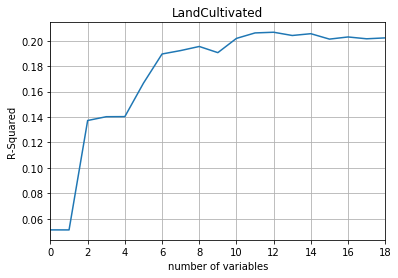

In [116]:
from sklearn.model_selection import train_test_split

variable_to_predict="LandCultivated"

X_all=data.loc[:,all_features] # features
#Y_all=data.loc[:,data.columns=="Food_Availability_kCal_MAE_day"] # targets
Y_all=data.loc[:,data.columns==variable_to_predict] # targets

Y_not_na=Y_all[Y_all[variable_to_predict].notna()]
X_not_na=X_all[Y_all[variable_to_predict].notna()]

Y=Y_not_na[identify_outlier_rows(Y_not_na[variable_to_predict])]
X=X_not_na[identify_outlier_rows(Y_not_na[variable_to_predict])]

X_train, X_test, Y_train, Y_test=train_test_split(X,Y, test_size=0.2)



#------------------- Preprocessing Data --------------------######
print("Preprocessing Data")
from sklearn import preprocessing #useful for replacing NaNs


X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
#X.dropna(axis=1, thresh=int(X.shape[0]/4), inplace=True) # dropping columns with all NAs
X_train.dropna(axis=1, how="all", inplace=True)
X_train.dropna(axis=0, how="all", inplace=True) # dropping rows with all NAs


#X_train.fillna(X_train.median(), inplace=True) #replacing NAs with the mean value as 

#---------- Normalising all variables for RFE -----------------#
print("Normalising all variables for RFE")

temp = X_train.values #returns a numpy array

#min_max_scaler = preprocessing.MinMaxScaler(feature_range = (0, 1)) #min max scaler
#temp_scaled = min_max_scaler.fit_transform(temp)
robust_scaler=preprocessing.RobustScaler() #min max scaler
temp_scaled = robust_scaler.fit_transform(temp)

X_scaled = pd.DataFrame(temp_scaled)
X_scaled.columns=[column for column in X_train.columns]


#------------ Recursive feature elimination RFE ----------#
print("Recursive feature elimination RFE")

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
 

names = X_train.columns
 
#use linear regression as the model
lm = LinearRegression()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lm, n_features_to_select=1)
rfe.fit(X_train,Y_train)


ranked_importance=pd.DataFrame(zip(rfe.ranking_,X_train.columns), )
ranked_importance.columns=["ranking", "variable"]
ranked_importance.loc[ranked_importance["ranking"]==1,]
ranked_importance=ranked_importance.sort_values("ranking")

top_50_ranked_importance=ranked_importance[0:50]
file_name_temp=os.path.join("exploratory_outputs", variable_to_predict+"_50_Most_important_RFE.csv")
top_50_ranked_importance.to_csv(file_name_temp)

# Attributes of RFE: n_features, support (the mask of selected features), ranking_estimator_

#----------------- Iterative linear regression whilst adding most important variables -------------#
print("Iterative linear regression whilst adding most important variables")


from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

columns_to_include=[]
r2_score_list=[]
for number_of_variables in ranked_importance["ranking"]:
    if number_of_variables<100:
        columns_to_include.append(ranked_importance.loc[ranked_importance["ranking"]==number_of_variables,"variable"].values[0])
        X_temp=X_train.loc[:,columns_to_include]

        lm = linear_model.LinearRegression()
        lm.fit(X_temp, Y_train)
        
        
        X_test.fillna(X_test.median(), inplace=True) #replacing NAs with the mean value as 
        #X_test.dropna(axis=0,inplace=True)
        #X_test.dropna(axis=1,inplace=True)

        Y_pred=lm.predict(X_test.loc[:,columns_to_include])
        mean_squared_error(Y_test,Y_pred)
        r2_score_list.append(r2_score(Y_test,Y_pred))
    else:
        break

#----------------- Plotting R-squared for variables added -------------#
print("Plotting R-squared for variables added")

r2_dataframe=pd.DataFrame(r2_score_list[0:19])
r2_dataframe.columns=["r2"]
fig, ax= plt.subplots()
r2_dataframe["r2"].plot(ax=ax, kind="line",title=variable_to_predict, grid=True)
ax.set_xlabel("number of variables")
ax.set_ylabel("R-Squared")
file_name_temp=os.path.join("exploratory_outputs", variable_to_predict+"_R_SQUARED_plot_RFE.png")
plt.savefig(file_name_temp)


In [118]:
lm.coef_

array([[ 7.41352506e-01,  5.04251555e-02, -2.96191920e-02,
         1.16045640e-02, -6.53206654e-03, -4.41343150e-01,
         3.09505385e-01, -2.23319154e-01,  1.82596124e-01,
        -1.35301769e-01, -3.88562514e-03,  1.57655483e-01,
         5.90029887e-03, -3.36010313e-01,  5.29768592e-02,
        -5.58333196e-01, -8.27515578e-02,  2.72873705e-03,
        -1.19007373e-03,  1.29341359e-03, -3.59344544e-02,
        -2.57145475e-03,  1.11462906e-05,  1.65922486e-05,
         2.13280620e-04,  2.45331262e-04, -3.14228829e-05,
        -5.97402372e-04, -5.87094086e-04, -1.28081594e-05,
         1.57765301e-04, -2.36332639e-04,  2.92079293e-04,
        -2.44790922e-03, -2.23346899e-03,  8.59711291e-05,
         3.69492154e-05, -1.40641629e-03, -7.13749441e-03,
        -3.10115804e-04, -8.80394364e-05, -2.77220185e-03,
         1.59812001e-03, -8.42276679e-04,  1.71751999e-03,
        -2.80512040e-03, -3.33263325e-03,  2.52694392e-03,
         1.43041480e-03,  1.94400939e-05,  1.79261500e-0

In [103]:
#------------------ Variance threshold feature selection ---------------#
# https://chrisalbon.com/machine_learning/feature_selection/variance_thresholding_for_feature_selection/
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(test_data, threshold):
    selector = VarianceThreshold(threshold)
    selector.fit(test_data)
    return test_data[test_data.columns[selector.get_support(indices=True)]]

variance_over_threshold=variance_threshold_selector(test_data=X_scaled,threshold=0.5)


#variance_over_threshold.columns

(9612, 416)

In [306]:
#------------ Train Test Split ----------------# 

from sklearn.model_selection import train_test_split

X=data.loc[:,columns_in_raster] # features
Y=data.loc[:,data.columns=="LandCultivated"] # targets


X_train, X_test, Y_train, Y_test=train_test_split(X,Y, test_size=0.2)

#------------ K-fold cross validation ----------------# 
from sklearn.model_selection import KFold # import KFold

kf = KFold(n_splits=10) # Define the split - into 2 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator

print(kf) 
KFold(n_splits=10, random_state=None, shuffle=False)

KFold(n_splits=10, random_state=None, shuffle=False)


KFold(n_splits=10, random_state=None, shuffle=False)

In [ ]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

# Create a model for feature selection
estimator = RandomForestClassifier(n_estimators = 100,  n_jobs = -1)

# Create the object
selector = RFECV(estimator, step = 1, cv = 3, 
                 scoring= scorer, n_jobs = -1)

# Fit on training data
selector.fit(train, train_labels)

# Transform data
train_selected = selector.transform(train)
test_selected = selector.transform(test)


In [103]:
coefficient

0   -0.072858
1   -0.624199
2   -0.459384
3   -0.113675
dtype: float64

Preprocessing Data
Normalising all variables for RFE
Optimal number of features : 345


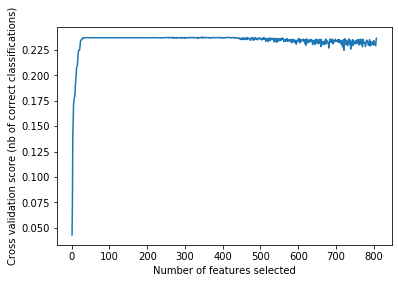

In [128]:
from sklearn.model_selection import train_test_split

variable_to_predict="LandCultivated"

X_all=data.loc[:,all_features] # features
#Y_all=data.loc[:,data.columns=="Food_Availability_kCal_MAE_day"] # targets
Y_all=data.loc[:,data.columns==variable_to_predict] # targets

Y_not_na=Y_all[Y_all[variable_to_predict].notna()]
X_not_na=X_all[Y_all[variable_to_predict].notna()]

Y=Y_not_na[identify_outlier_rows(Y_not_na[variable_to_predict])]
X=X_not_na[identify_outlier_rows(Y_not_na[variable_to_predict])]

X_train, X_test, Y_train, Y_test=train_test_split(X,Y, test_size=0.2)



#------------------- Preprocessing Data --------------------######
print("Preprocessing Data")
from sklearn import preprocessing #useful for replacing NaNs


X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
#X.dropna(axis=1, thresh=int(X.shape[0]/4), inplace=True) # dropping columns with all NAs
X_train.dropna(axis=1, how="all", inplace=True)
X_train.dropna(axis=0, how="all", inplace=True) # dropping rows with all NAs


#X_train.fillna(X_train.median(), inplace=True) #replacing NAs with the mean value as 

#---------- Normalising all variables for RFE -----------------#
print("Normalising all variables for RFE")

temp = X_train.values #returns a numpy array

#min_max_scaler = preprocessing.MinMaxScaler(feature_range = (0, 1)) #min max scaler
#temp_scaled = min_max_scaler.fit_transform(temp)
robust_scaler=preprocessing.RobustScaler() #min max scaler
temp_scaled = robust_scaler.fit_transform(temp)

X_scaled = pd.DataFrame(temp_scaled)
X_scaled.columns=[column for column in X_train.columns]


#------------ Recursive feature elimination RFE with cross validation  and ridge regrssion----------#

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
#X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
#                           n_redundant=2, n_repeated=0, n_classes=8,
#                           n_clusters_per_class=1, random_state=0)

# Create the RFE object and compute a cross-validated score.
lm = linear_model.Ridge()
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=lm, step=1, cv=5,
              scoring='r2')
rfecv.fit(X_train, Y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
basic_model = pm.Model()
    with basic_model:
        # Create the glm using the Patsy model syntax
        # We use a Normal distribution for the likelihood
        pm.glm.glm("y ~ x", df, family=pm.glm.families.Normal())

        # Use Maximum A Posteriori (MAP) optimisation as initial value for MCMC
        start = pm.find_MAP()

        # Use the No-U-Turn Sampler
        step = pm.NUTS()

        # Calculate the trace
        trace = pm.sample(
            iterations, step, start, 
            random_seed=42, progressbar=True
        )
        
trace = glm_mcmc_inference(df, iterations=5000)
    pm.traceplot(trace[500:])
    plt.show()

# Bayesian Modelling With PyMC3 #

In [130]:
from pymc3 import  *

import numpy as np
import matplotlib.pyplot as plt

In [131]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

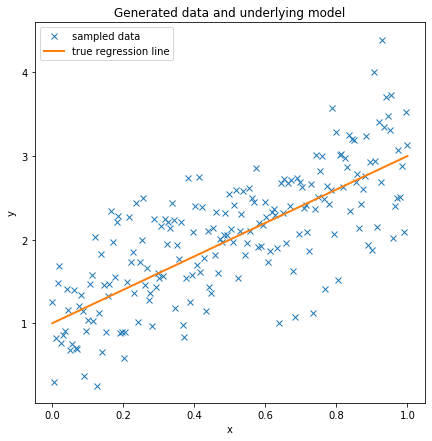

In [136]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [144]:
data=None
x=None
y=None
with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy('sigma', beta=10, testval=1.)
    intercept = Normal('Intercept', 0, sigma=20)
    x_coeff = Normal('x', 0, sigma=20)

    # Define likelihood
    likelihood = Normal('y', mu=intercept + x_coeff * x,
                        sigma=sigma, observed=y)

    # Inference!
    trace = sample(3000, cores=2) # draw 3000 posterior samples using NUTS sampling

TypeError: unsupported operand type(s) for *: 'FreeRV' and 'NoneType'

<Figure size 1440x1440 with 0 Axes>

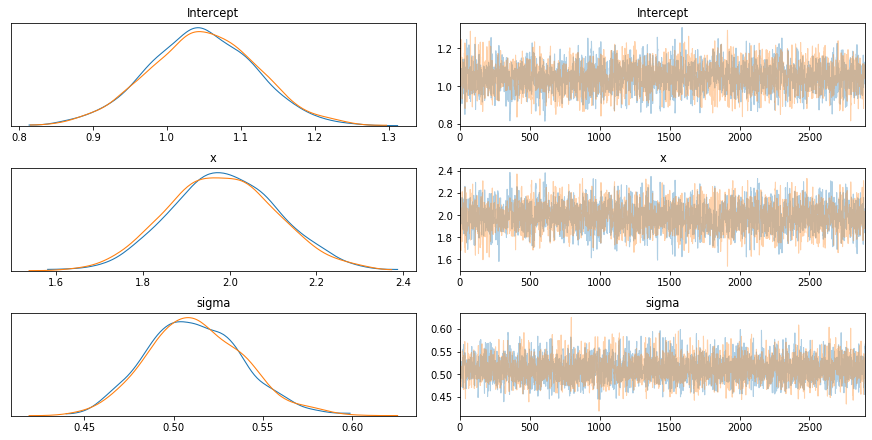

In [143]:
plt.figure(figsize=(20, 20))
traceplot(trace[100:])
plt.show();

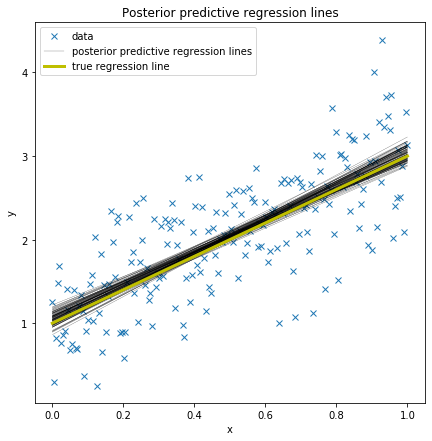

In [141]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
plot_posterior_predictive_glm(trace, samples=100,
                              label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');